In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
for k in range(0,1):
    mpl.rcParams["axes.labelsize"] = fs
    mpl.rcParams["axes.titlesize"] = fs
    mpl.rcParams["xtick.labelsize"] =  fs
    mpl.rcParams["ytick.labelsize"] =  fs
    mpl.rcParams["legend.fontsize"] =  fs
    mpl.rcParams['font.sans-serif'] = ['Times New Roman']
    mpl.rcParams['font.serif'] = ['Times New Roman']
    mpl.rcParams['axes.unicode_minus'] = False

In [2]:
def RunStandalone(D_e,D_EC,D_cross,t_0plus,trans_i,j_tot_n_num,j_tot_p_num,j_SEI_n_num,i_eley,t_in_s):
        F = 96485.33;       # Faraday constant in C/mol

        c_init = 1000;      # Initial Li-ion concentration in electrolyte
        c_EC_init= 4000;    # Initial EC  concentration in electrolyte 
        c_tot_init = 6000;  # Initial total concentration in electrolyte

        V_bar_SEI = 9.585e-5;  # SEI partial molar volume in m3/mol
        V_bar_EC  = 6.667e-5;  # EC  partial molar volume in m3/mol
        V_bar_Li  = 1.300e-5;  # Li+ partial molar volume in m3/mol

        b = 1.5;    # Bruggman cofficient

        R_n       = 5.86e-6   # Mean Neg particle radius in m
        R_p       = 5.22e-6   # Mean Pos particle radius in m

        # Should be a variable but now set as constant to simplify
        epislon_n = 0.25;     # Neg porosity
        epislon_s = 0.47;     # Sep porosity
        epislon_p = 0.335;     # Sep porosity

        epislon_n = pybamm.FullBroadcast(
                        pybamm.Scalar(0.25), "negative electrode", )
        epislon_s = pybamm.FullBroadcast(
                pybamm.Scalar(0.47), "separator", )
        epislon_p = pybamm.FullBroadcast(
                pybamm.Scalar(0.335), "positive electrode", )
        epislon = pybamm.concatenation(epislon_n, epislon_s, epislon_p )

        # During Discharge: j_int_neg is positive; j_SEI is also positive; 
        # but j_int_pos is negative
        # Total Neg interfacial current density in A/m2
        
        j_tot_n = pybamm.FullBroadcast(
                        pybamm.Scalar(j_tot_n_num), "negative electrode", )
        j_tot_s = pybamm.FullBroadcast(
                pybamm.Scalar(0), "separator", )
        # Total Pos interfacial current density in A/m2
        j_tot_p = pybamm.FullBroadcast(
                pybamm.Scalar(j_tot_p_num), "positive electrode", )
        j_tot = pybamm.concatenation(j_tot_n, j_tot_s, j_tot_p )

        j_SEI_n = pybamm.FullBroadcast(
                pybamm.Scalar(j_SEI_n_num), "negative electrode", )
        j_SEI_s = pybamm.FullBroadcast(
                pybamm.Scalar(0), "separator", )
        j_SEI_p = pybamm.FullBroadcast(
                pybamm.Scalar(0), "positive electrode", )
        j_SEI   = pybamm.concatenation(j_SEI_n,j_SEI_s,j_SEI_p);      # SEI       interfacial current density in A/m2
        

        a_n = 3* epislon_n / R_n    # Neg Specific surface area
        a_p = 3* epislon_p / R_p    # Neg Specific surface area
        zero_s = pybamm.FullBroadcast(0, "separator")
        sign_2_n = pybamm.FullBroadcast(
                pybamm.Scalar(1), "negative electrode", )
        sign_2_s = pybamm.FullBroadcast(
                pybamm.Scalar(0), "separator", )
        sign_2_p = pybamm.FullBroadcast(
                pybamm.Scalar(0), "positive electrode", )
        sign_2 = pybamm.concatenation(sign_2_n, sign_2_s, sign_2_p )
        a = pybamm.concatenation(a_n, zero_s, a_p)
        model = pybamm.BaseModel()
        c_e_n  = pybamm.Variable("Li+ concentration in negative electrode", domain="negative electrode")
        c_EC_n = pybamm.Variable("EC concentration in negative electrode", domain="negative electrode")

        c_e_s  = pybamm.Variable("Li+ concentration in separator", domain="separator")
        c_EC_s = pybamm.Variable("EC concentration in separator", domain="separator")

        c_e_p  = pybamm.Variable("Li+ concentration in positive electrode", domain="positive electrode")
        c_EC_p = pybamm.Variable("EC concentration in positive electrode", domain="positive electrode")

        c_EC = pybamm.concatenation(c_EC_n, c_EC_s, c_EC_p)
        c_e  = pybamm.concatenation(c_e_n, c_e_s, c_e_p)
        model.variables = {
                "Li+ concentration in negative electrode":c_e_n,
                "Li+ concentration in separator":c_e_s,
                "Li+ concentration in positive electrode":c_e_p,
                "EC concentration in negative electrode":c_EC_n,
                "EC concentration in separator":c_EC_s,
                "EC concentration in positive electrode":c_EC_p,}
        model.variables.update({
                "Li+ concentration": c_e, 
                "EC concentration": c_EC,
                "Porosity times Li+ concentration": c_e*epislon, 
                "Porosity times EC concentration": c_EC*epislon,
                })
        model.length_scales = {
        "negative electrode": 8.52e-5,
        "separator": 1.2e-5,
        "positive electrode": 7.56e-5,}
        model.timescale = pybamm.Scalar(8.52e-5 ** 2 /  D_e) 

        # define geometry
        x_n = pybamm.SpatialVariable(
        "x_n", 
        domain=["negative electrode"], 
        coord_sys="cartesian"
        )
        x_s = pybamm.SpatialVariable(
        "x_s", 
        domain=["separator"], 
        coord_sys="cartesian"
        )
        x_p = pybamm.SpatialVariable(
        "x_p", 
        domain=["positive electrode"], 
        coord_sys="cartesian"
        )
        x_all  = pybamm.concatenation(x_n, x_s, x_p)
        model.rhs = {
        c_e: 
        epislon**b *D_e*pybamm.div(pybamm.grad(c_e))  # 
        + epislon**b *D_cross/2*(c_init/c_tot_init)*pybamm.div(pybamm.grad(c_EC))#
        + a*(1-t_0plus)*j_tot/F 
        #- a*sign_2*(j_SEI*V_bar_EC+j_tot*V_bar_Li-0.5*j_SEI*V_bar_SEI)*c_init/F  
        ,

        c_EC:
        epislon**b *D_cross/2*(c_EC_init/c_tot_init)*pybamm.div(pybamm.grad(c_e))#
        + epislon**b *D_EC*pybamm.div(pybamm.grad(c_EC))#
        + sign_2 *    (
                a*trans_i*j_tot/F
                +a* (1+trans_i)*j_SEI/F
        #        -a*(j_SEI*V_bar_EC+j_tot*V_bar_Li-0.5*j_SEI*V_bar_SEI)*c_EC_init/F
        ) } 
        model.initial_conditions = {c_e: pybamm.Scalar(c_init),c_EC: pybamm.Scalar(c_EC_init)}

        model.boundary_conditions = {
        c_e: {"left": (pybamm.Scalar(0), "Neumann"),"right": (pybamm.Scalar(0), "Neumann")},  
        c_EC:{"left": (pybamm.Scalar(0), "Neumann"),"right": (pybamm.Scalar(0), "Neumann")} }

        geometry = {
        "negative electrode": {x_n: {"min": pybamm.Scalar(0), "max": pybamm.Scalar(8.52e-5)}},
        "separator":          {x_s: {"min": pybamm.Scalar(8.52e-5), "max": pybamm.Scalar(9.72e-5)}},
        "positive electrode": {x_p: {"min": pybamm.Scalar(9.72e-5), "max": pybamm.Scalar(17.28e-5)}},
        }
        # mesh and discretise ,"separator","positive electrode"
        submesh_types = {
        "negative electrode": pybamm.MeshGenerator(pybamm.Uniform1DSubMesh),
        "separator": pybamm.MeshGenerator(pybamm.Uniform1DSubMesh),
        "positive electrode": pybamm.MeshGenerator(pybamm.Uniform1DSubMesh),
        }
        var_pts = {x_n: 20, x_s:20, x_p:20}
        mesh = pybamm.Mesh(geometry, submesh_types, var_pts)
        spatial_methods = {
        "negative electrode": pybamm.FiniteVolume(),
        "separator": pybamm.FiniteVolume(),
        "positive electrode": pybamm.FiniteVolume(),
        }
        disc = pybamm.Discretisation(mesh, spatial_methods)
        disc.process_model(model);
        # solve
        solver = pybamm.ScipySolver()
        solution = solver.solve(model, [0,t_in_s])
        pybamm.dynamic_plot(solution,
        [
                "Li+ concentration",
                "EC concentration",
                "Porosity times Li+ concentration", 
                "Porosity times EC concentration",
        ],)
        return

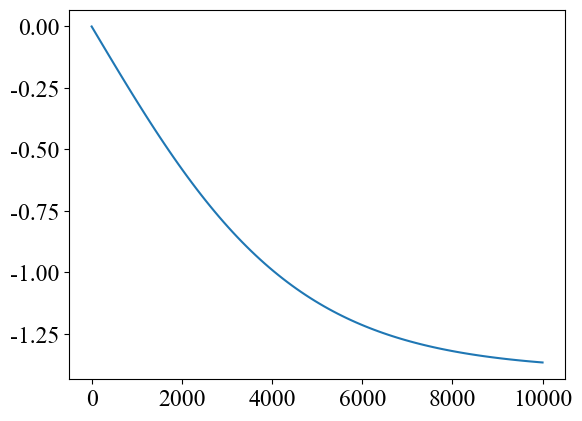

In [3]:
c_ec_test = np.linspace(0,1e4,100);
c_ec_typ = 4541
Xi_ec = np.tanh(c_ec_test/4541)   *(-1.4)
plt.plot(c_ec_test,Xi_ec)

In [4]:
# parameter - dimensional 
D_e     = 3e-10;    # Li+ diffusivity in m2/s
D_EC    = 5e-10;    # EC  diffusivity in m2/s
D_cross = 1.5e-9;  # Cross diffusivity in m2/s
# based on wip\Rio_Code\P3_R0\Check_eley_current_dens.ipynb
i_eley = 50;         # Electrolyte current density [A.m-2]
t_0plus = 0.3;      # Transference number for Li+
trans_i = -1.4;     # Transference number for EC  
j_tot_n_num = 2.1;j_tot_p_num=-1.7;j_SEI_n_num = 1e-3;
t_in_s = 30000
RunStandalone(D_e,D_EC,D_cross,t_0plus,trans_i,j_tot_n_num,j_tot_p_num,j_SEI_n_num,i_eley,t_in_s)


interactive(children=(FloatSlider(value=0.0, description='t', max=8.333333333333332, step=0.08333333333333331)…

print( epislon**b *D_e )
print( epislon**b *D_cross*(c_init/c_tot_init))
print( a*(1-t_0plus)*j_tot/F
    - a*sign_2*(j_SEI*V_bar_EC+j_tot*V_bar_Li-0.5*j_SEI*V_bar_SEI)*c_init/F)

print( epislon**b *D_cross*(c_EC_init/c_tot_init) )
print( epislon**b *D_EC   )
print( sign_2 * (
        a*trans_i*j_tot/F
        +a* (1+trans_i)*j_SEI/F
        -a*(j_SEI*V_bar_EC+j_tot*V_bar_Li-0.5*j_SEI*V_bar_SEI)*c_EC_init/F
    ))

In [5]:
RunStandalone(D_e,D_EC,D_cross,t_0plus,trans_i,j_tot_n_num/100,j_tot_p_num/100,0,i_eley,t_in_s) #
RunStandalone(D_e,D_EC,D_cross,t_0plus,trans_i/100,j_tot_n_num,j_tot_p_num,0,i_eley,72000) #


interactive(children=(FloatSlider(value=0.0, description='t', max=8.333333333333332, step=0.08333333333333331)…

interactive(children=(FloatSlider(value=0.0, description='t', max=20.0, step=0.2), Output()), _dom_classes=('w…